In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
def make_barplot(title:str,y_axis:str,nodes:list[dict]|dict):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(nodes.keys(),nodes.values())
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    plt.title(title, fontsize=14)
    plt.xlabel("Node Label", fontsize=12)
    plt.ylabel(y_axis, fontsize=12)
    plt.xticks(list(nodes.keys()))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [3]:
def determine_shortest_path(working_nodes):
    all_shortest_paths = {}
    for node in working_nodes.nodes():
        try:
            to_29 = nx.shortest_path_length(working_nodes, source=node, target=29)
            to_5 = nx.shortest_path_length(working_nodes, source=node, target=5)
            all_shortest_paths[node] = (to_29 + to_5)/2
        except nx.NetworkXNoPath:
            all_shortest_paths[node] = 0
    return all_shortest_paths

In [4]:
def plot_road_network(title,working_nodes):
    nodes, edges = ox.graph_to_gdfs(working_nodes)
    fig, ax = plt.subplots(figsize=(8, 8))
    edges.plot(ax=ax, color="blue", linewidth=1, alpha=0.8, label="Roads")
    nodes.plot(ax=ax, color="red", markersize=10, label="Intersections")
    for node_id, row in nodes.iterrows():
        x, y = row.geometry.x, row.geometry.y
        ax.text(x, y, str(row.name), fontsize=6, ha='center', va='center', color='black', alpha=0.7,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle="round,pad=0.2"))
    ax.set_title(title, fontsize=14)
    ax.legend()
    plt.show()
    print('Number of intersections:', working_nodes.number_of_nodes())
    print('Number of road segments:', working_nodes.number_of_edges())

In [5]:
# Define the target area
city = 'Hernesaari, Helsinki, Finland'

# Download the administrative boundaries
admin = ox.geocode_to_gdf(city)

# Download the road network, filtering for drivable roads
G = ox.graph_from_polygon(admin.geometry.to_list()[0], network_type='drive')

for i, node in enumerate(list(G.nodes())):
    G = nx.relabel_nodes(G, {node: i+1})


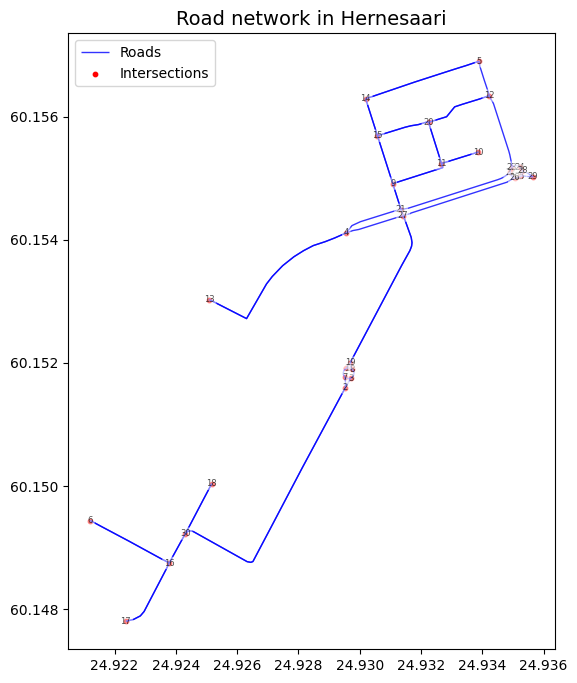

Number of intersections: 30
Number of road segments: 56


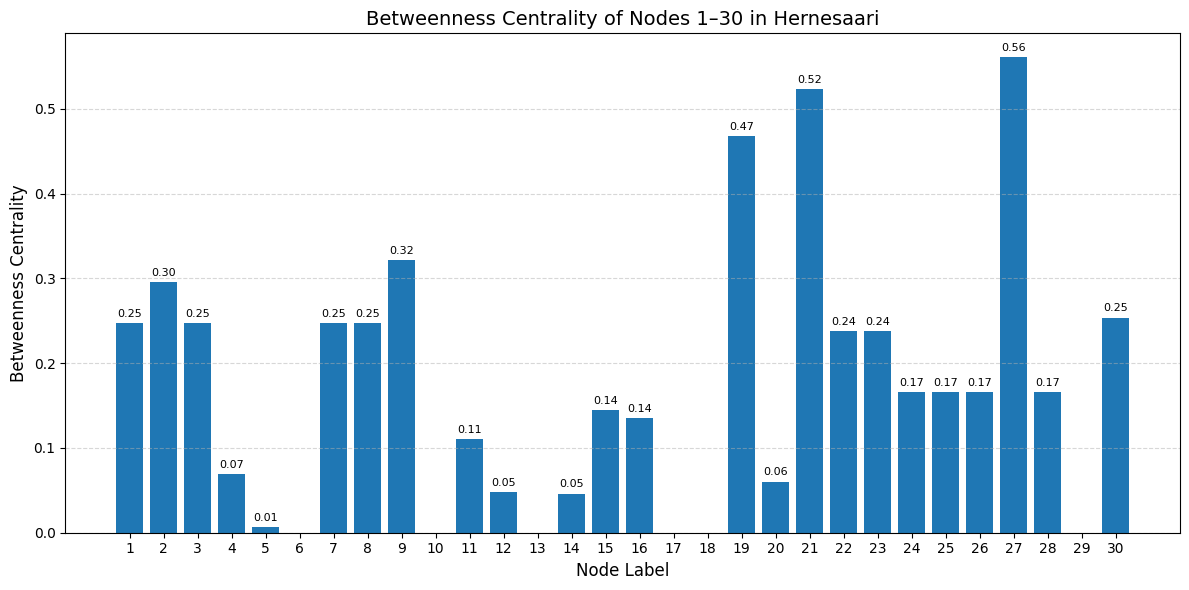

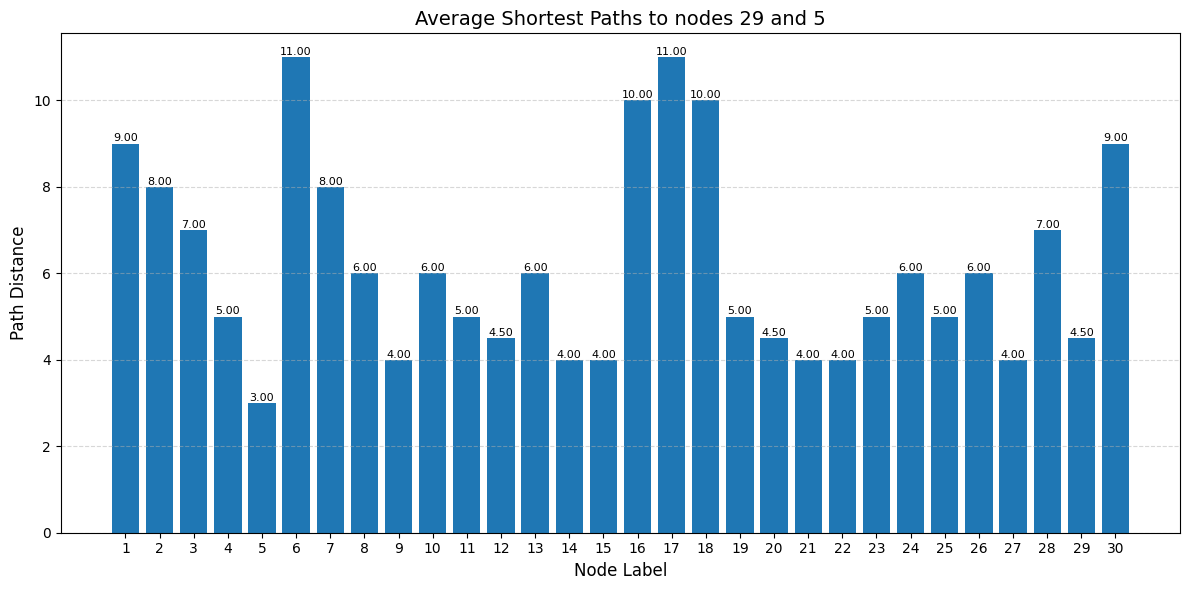

In [6]:
plot_road_network("Road network in Hernesaari",G)
centrality_full = nx.betweenness_centrality(G)
make_barplot("Betweenness Centrality of Nodes 1–30 in Hernesaari","Betweenness Centrality",centrality_full)
shortest_paths = determine_shortest_path(G)
make_barplot("Average Shortest Paths to nodes 29 and 5","Path Distance",shortest_paths)

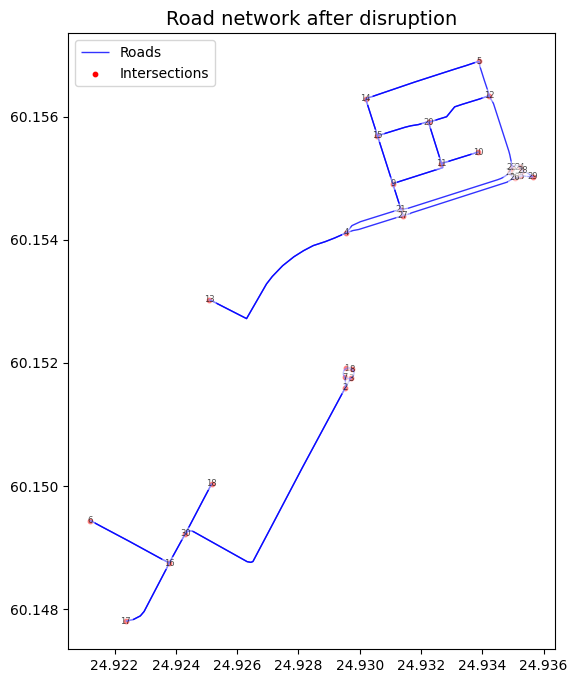

Number of intersections: 29
Number of road segments: 52


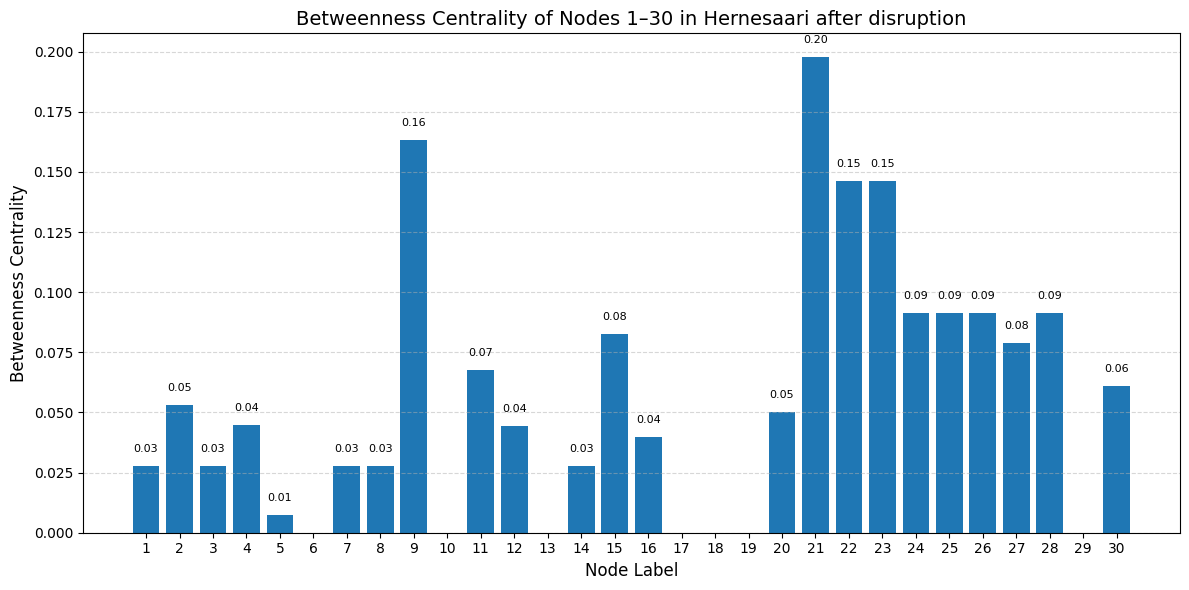

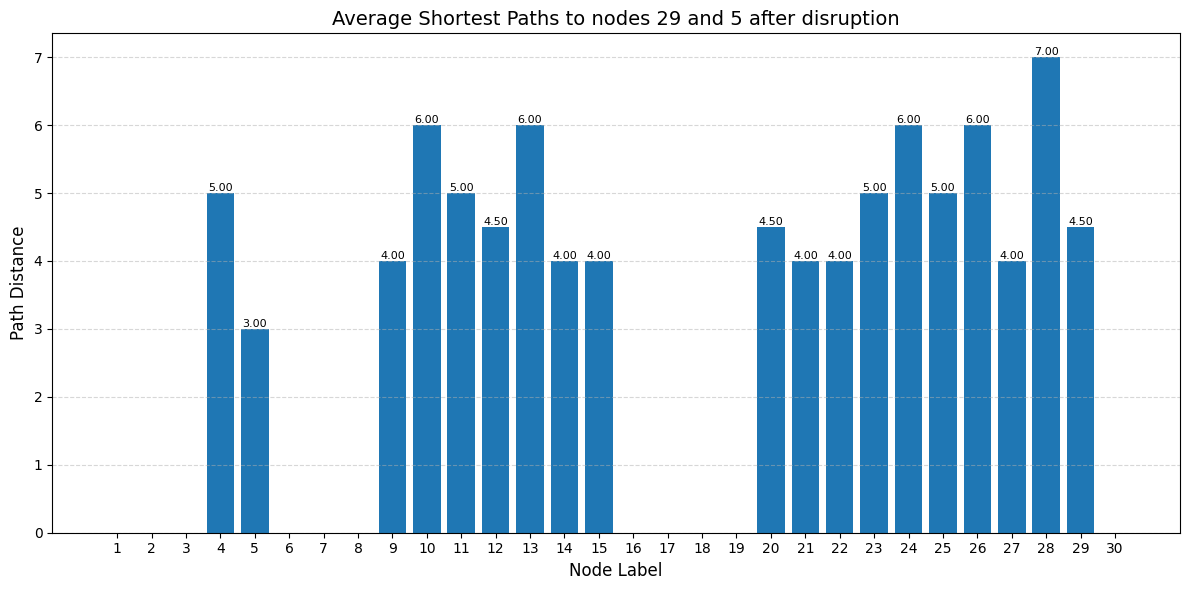

In [7]:
## Simulate the disruption by removing the edges connected to nodes 21 and 27
disrupted_nodes = [19]
G_disrupted = G.copy()  # Make a copy of the graph to avoid modifying the original

# Remove the edges connected to the disrupted nodes
for node in disrupted_nodes:
    G_disrupted.remove_node(node)
    # if node in G_disrupted.nodes:
    #     # Remove incoming and outgoing edges from the disrupted nodes
    #     G_disrupted.remove_edges_from(list(G_disrupted.edges(node)))

plot_road_network("Road network after disruption",G_disrupted)
centrality_disrupted = nx.betweenness_centrality(G_disrupted)
centrality_disrupted[19] = 0
make_barplot("Betweenness Centrality of Nodes 1–30 in Hernesaari after disruption","Betweenness Centrality",centrality_disrupted)
shortest_paths_disrupted = determine_shortest_path(G_disrupted)
shortest_paths_disrupted[19] = 0
make_barplot("Average Shortest Paths to nodes 29 and 5 after disruption","Path Distance",shortest_paths_disrupted)


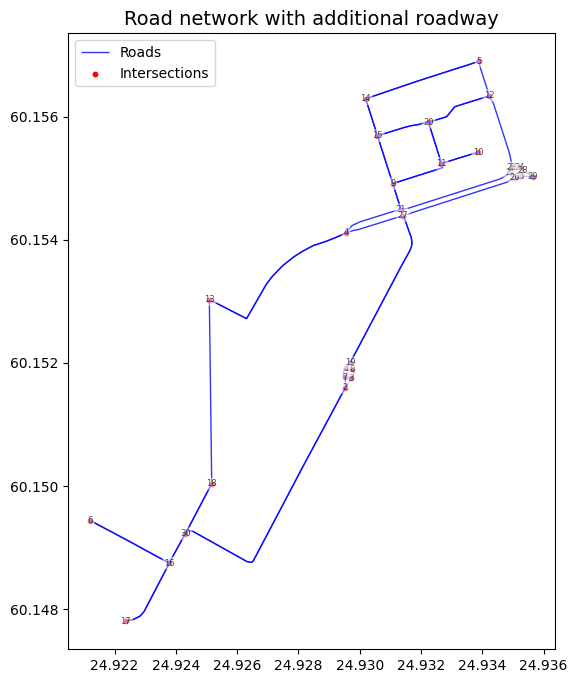

Number of intersections: 30
Number of road segments: 57


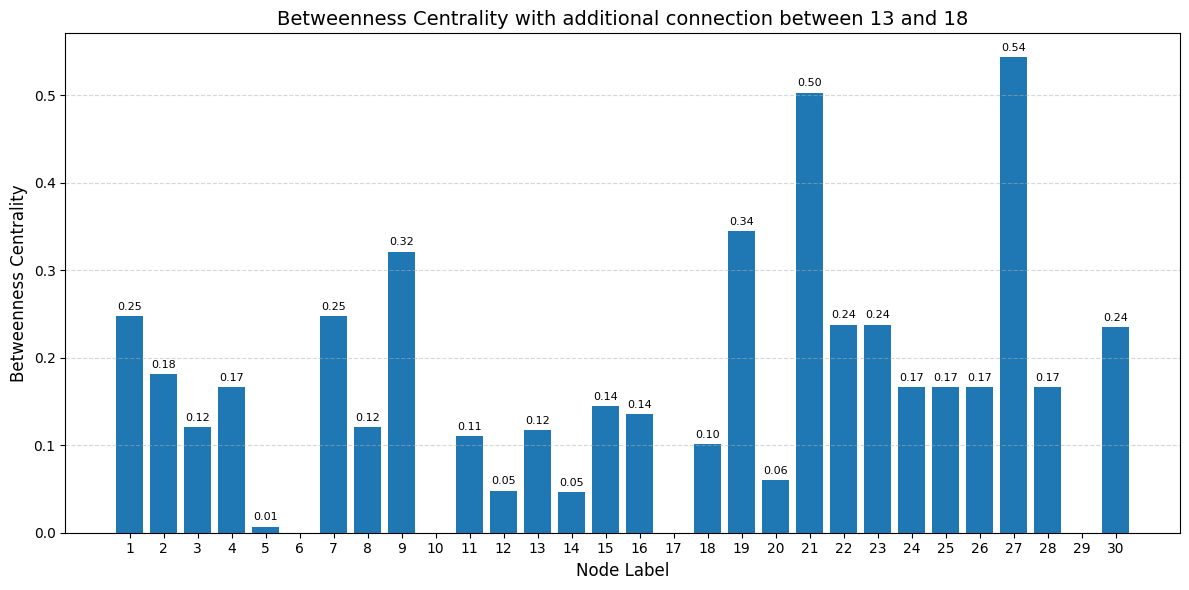

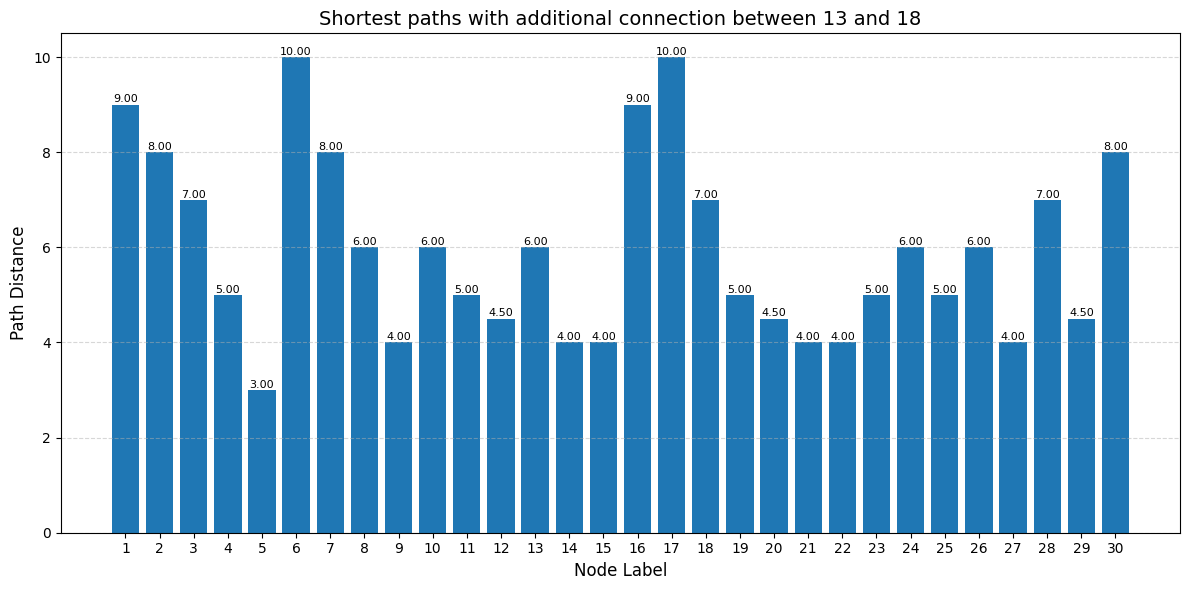

In [8]:
node_subset = G.copy()
for i, node in enumerate(list(node_subset.nodes())):
    node_subset = nx.relabel_nodes(node_subset, {node: i+1})
node_subset.add_edge(18, 13, length=ox.distance.euclidean(node_subset.nodes[18]['y'], node_subset.nodes[18]['x'], node_subset.nodes[13]['y'], node_subset.nodes[13]['x']))
plot_road_network("Road network with additional roadway",node_subset)
betweenness = nx.betweenness_centrality(node_subset)
make_barplot("Betweenness Centrality with additional connection between 13 and 18", "Betweenness Centrality", betweenness)
extra_shortest_paths = determine_shortest_path(node_subset)
make_barplot("Shortest paths with additional connection between 13 and 18","Path Distance",extra_shortest_paths)


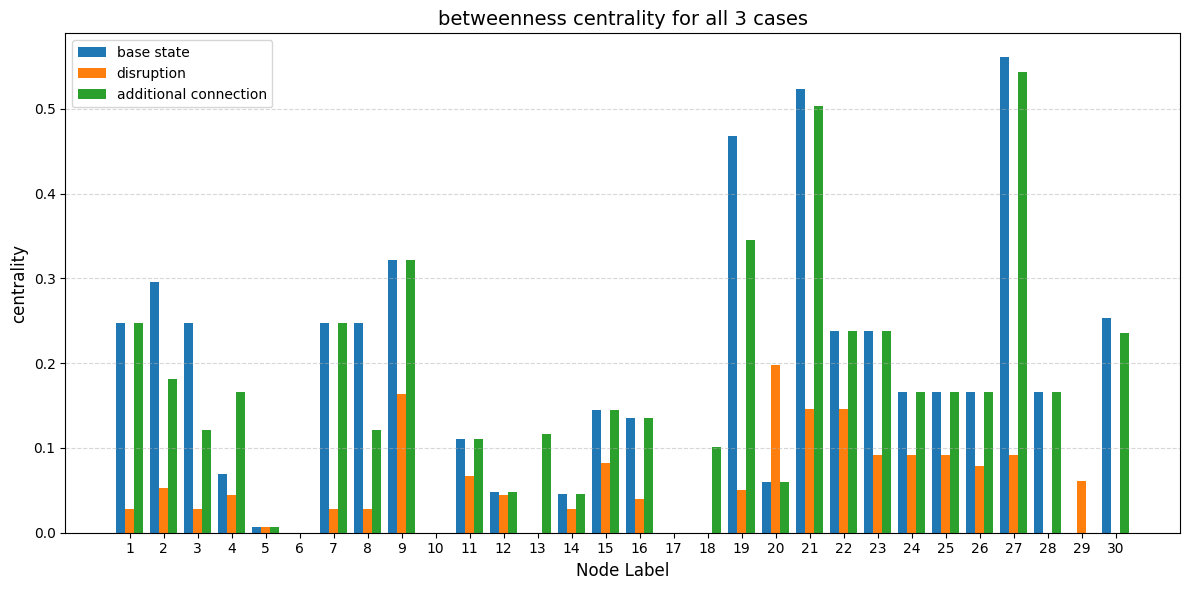

In [9]:
## Graphics
nodes = [centrality_full,centrality_disrupted,betweenness]
titles = ["base state","disruption","additional connection"]
labels = nodes[0].keys()
num_datasets = len(nodes)
plt.figure(figsize=(12, 6))
bar_width = 0.8 / num_datasets
for index,i in enumerate(nodes):
    x_pos = np.arange(len(labels)) + index * bar_width - (num_datasets - 1) * bar_width / 2 +1
    plt.bar(x_pos, i.values(), width=bar_width, label=titles[index])
plt.legend()
plt.title("betweenness centrality for all 3 cases", fontsize=14)
plt.xlabel("Node Label", fontsize=12)
plt.ylabel("centrality", fontsize=12)
plt.xticks(list(nodes[0].keys()))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

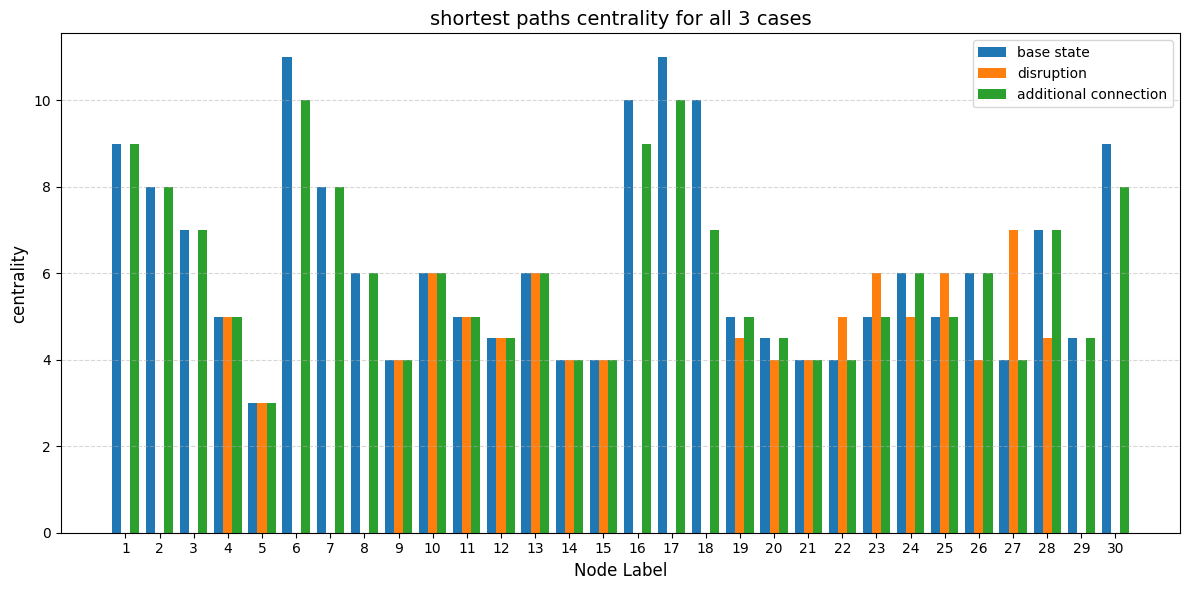

In [10]:
centrality_disrupted[21] = 0
centrality_disrupted[27] = 0
nodes = [shortest_paths,shortest_paths_disrupted,extra_shortest_paths]
titles = ["base state","disruption","additional connection"]
labels = nodes[0].keys()
num_datasets = len(nodes)
plt.figure(figsize=(12, 6))
bar_width = 0.8 / num_datasets
for index,i in enumerate(nodes):
    x_pos = np.arange(len(labels)) + index * bar_width - (num_datasets - 1) * bar_width / 2 +1
    plt.bar(x_pos, i.values(), width=bar_width, label=titles[index])
plt.legend()
plt.title("shortest paths centrality for all 3 cases", fontsize=14)
plt.xlabel("Node Label", fontsize=12)
plt.ylabel("centrality", fontsize=12)
plt.xticks(list(nodes[0].keys()))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()